### Hand pose estimation using `mediapipe`

In [2]:
import cv2,sys,time
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
sys.path.append("../utils")
from mujoco_parser import MuJoCoParserClass
from util import get_idxs,rpy2r
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("cv2:[%s]"%(cv2.__version__))
print ("mediapipe:[%s]"%(mp.__version__))

cv2:[4.9.0]
mediapipe:[0.10.9]


#### Load images from the video

In [32]:
mp4_path = '../data/bam_yang_gang.mp4'
cap      = cv2.VideoCapture(mp4_path)
n_frame  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
HZ       = int(cap.get(cv2.CAP_PROP_FPS))
print ("[%s] opened. #frame:[%d] HZ:[%d]"%(mp4_path,n_frame,HZ))
img_list = []
while cap.isOpened():
    ret,img_bgr = cap.read()
    if not ret: break
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_list.append(img_rgb)
print ("number of imgs:[%d]"%(len(img_list)))
print ("Done.")

[../data/bam_yang_gang.mp4] opened. #frame:[738] HZ:[30]
number of imgs:[738]
Done.


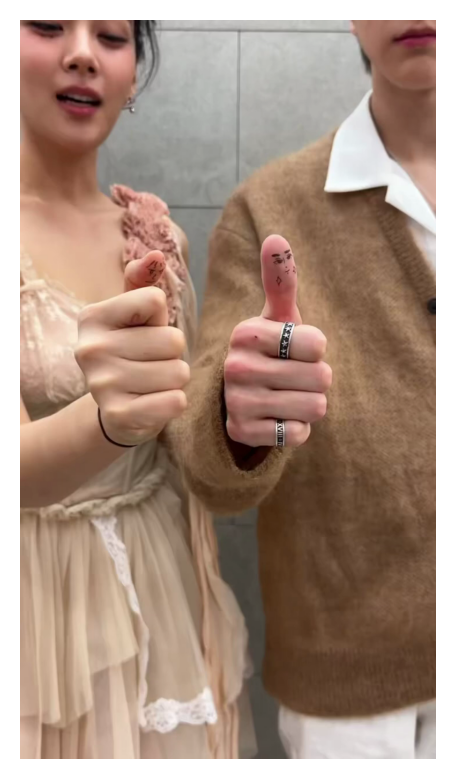

In [33]:
# Plot the first image
plt.imshow(img_list[0])
plt.axis('off')
plt.show()

#### Run hand pose estimation

In [34]:
# Initialize MediaPipe hand model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode        = False,
    max_num_hands            = 2,
    model_complexity         = 1,
    min_detection_confidence = 0.25,
    min_tracking_confidence  = 0.25,
)
mp_drawing = mp.solutions.drawing_utils
print ("Mediapipe hand model ready.")

Mediapipe hand model ready.


I0000 00:00:1711249264.651166       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro


In [35]:
img_with_res_list = []
print ("Start hand pose estimation of [%d] images..."%(n_frame))
VERBOSE = 0
for img_idx in range(n_frame):
    # Get image
    img = img_list[img_idx]
    # Run hand pose estimation
    res = hands.process(img)
    if VERBOSE:
        if res.multi_hand_landmarks:
            print ("[%d] #hand:[%d]"%(img_idx,len(res.multi_hand_landmarks)))
        else:
            print ("[%d] No hand"%(img_idx))
    img_with_res = img.copy()
    if res.multi_hand_landmarks:
        for hand_landmarks in res.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                img_with_res,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
            )
    # Put some text information on the image
    cv2.putText(
        img  = img_with_res,
        text = 'img_idx:[%d]'%(img_idx),
        org  = (20,40),
        fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 1,
        color     = (0,0,255),
        thickness = 2,
    )
    # Append
    img_with_res_list.append(img_with_res)
print ("Done.")

Start hand pose estimation of [738] images...
Done.


In [36]:
media.show_video(images=img_with_res_list,fps=HZ,width=200,downsample=False)

cap.release()
print ("Mediapipe released.")

Mediapipe released.


#### Now get 3D hand joints in `hand_pose_list`

In [37]:
img_start,img_end = 0,505
hand_pose_list = []
for img_idx in range(img_start,img_end): # for each frame
    img = img_list[img_idx] 
    res = hands.process(img) # run hand estimation
    n_landmark = 21 # fixed
    if res.multi_hand_world_landmarks: # if hands are detected
        n_detected_hand = len(res.multi_hand_world_landmarks) # number of detected hand(s)
        joint_xyzs_list = []
        for h_idx in range(n_detected_hand):
            joint_xyzs = np.zeros((n_landmark,3)) # [21 x 3]
            for l_idx in range(n_landmark): # for each landmark
                joint_xyzs[l_idx,0] = res.multi_hand_world_landmarks[h_idx].landmark[l_idx].x
                joint_xyzs[l_idx,1] = res.multi_hand_world_landmarks[h_idx].landmark[l_idx].y
                joint_xyzs[l_idx,2] = res.multi_hand_world_landmarks[h_idx].landmark[l_idx].z
            joint_xyzs_list.append(joint_xyzs)
        # Append
        hand_pose_list.append(joint_xyzs_list)
    else: # if no hand detected
        # Append
        hand_pose_list.append([])
print ("Done.")

Done.


In [38]:
cap.release()
print ("Mediapipe released.")

Mediapipe released.


![alt text](../data/hand_limbs.jpg)

In [39]:
# Match number of joints with Psyonic Hand
hand_pose_array = np.array(hand_pose_list[1:])
exclude = [4,8,12,16,20]
hand_idx_without_distal = [i for i in range(0,21) if i not in exclude]
hand_pose_array = hand_pose_array[:,1,hand_idx_without_distal,:]
print(hand_pose_array.shape)

# Filter the hand pose
import scipy
from scipy.ndimage import gaussian_filter1d

for i in range(16):
    for j in range(3):
        hand_pose_array[:,i,j] = gaussian_filter1d(hand_pose_array[:,i,j], sigma=3)

# Match dimensions with Psyonic Hand
psyonic_joint_idx_pairs = [[0,1],[1,2],[2,3],
                           [0,4],[4,5],[5,6],
                           [0,7],[7,8],[8,9],
                           [0,10],[10,11],[11,12],
                           [0,13],[13,14],[14,15]]
psyonic_limb_lengths = [0.0445638, 0.0314961, 0.0693509,
                        0.1050721, 0.0386104, 0.0402492,
                        0.1050354, 0.0386104, 0.0402492,
                        0.1029072, 0.0386104, 0.0402492,
                        0.1008422, 0.0386104, 0.0402492]
for i in range(hand_pose_array.shape[0]):
    for j in range(len(psyonic_limb_lengths)):
        idx_pair = psyonic_joint_idx_pairs[j]
        v = hand_pose_array[i,idx_pair[1],:] - hand_pose_array[i,idx_pair[0],:]
        hand_pose_array[i,idx_pair[1],:] = psyonic_limb_lengths[j] * v / np.linalg.norm(v) + hand_pose_array[i,idx_pair[0],:]

(504, 16, 3)


#### Animate the hand 3D joints in `MuJoCo`

In [3]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=True)
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,1]

BODY_NAMES = ['robot2/thumb_L1', 'robot2/thumb_L2', 'robot2/thumb_tip',
              'robot2/index_L1', 'robot2/index_L2','robot2/index_tip',
              'robot2/middle_L1', 'robot2/middle_L2', 'robot2/middle_tip',
              'robot2/ring_L1', 'robot2/ring_L2', 'robot2/ring_tip',
              'robot2/pinky_L1', 'robot2/pinky_L2', 'robot2/pinky_tip']

JOINT_NAMES = ['robot2/joint6',
               'robot2/index_q1', 'robot2/index_q2', 
               'robot2/middle_q1', 'robot2/middle_q2', 
               'robot2/ring_q1', 'robot2/ring_q2', 
               'robot2/pinky_q1', 'robot2/pinky_q2', 
               'robot2/thumb_q1', 'robot2/thumb_q2']

dt:[0.0020] HZ:[500]
n_dof (=nv):[32]
n_geom:[55]
geom_names:[None, None, None, None, None, None, 'floor', None, None, None, None, None, None, None, None, None, None, None, None, 'robot1/wrist_mesh', 'robot1/palm_mesh', 'robot1/index_mesh_1', 'robot1/index_mesh_2', 'robot1/middle_mesh_1', 'robot1/middle_mesh_2', 'robot1/ring_mesh_1', 'robot1/ring_mesh_2', 'robot1/pinky_mesh_1', 'robot1/pinky_mesh_2', 'robot1/thumb_mesh_1', 'robot1/thumb_mesh_2', None, None, None, None, None, None, None, None, None, None, None, None, 'robot2/wrist_mesh', 'robot2/palm_mesh', 'robot2/index_mesh_1', 'robot2/index_mesh_2', 'robot2/middle_mesh_1', 'robot2/middle_mesh_2', 'robot2/ring_mesh_1', 'robot2/ring_mesh_2', 'robot2/pinky_mesh_1', 'robot2/pinky_mesh_2', 'robot2/thumb_mesh_1', 'robot2/thumb_mesh_2']
n_body:[43]
body_names:['world', 'robot1/link2', 'robot1/link3', 'robot1/link4', 'robot1/link5', 'robot1/link6', 'robot1/end_link', 'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 'robot1/middle_L1

#### Single Frame

In [41]:
env.init_viewer(
    viewer_title  = "Dual Arms Retargeting",
    viewer_width  = 1200,
    viewer_height = 800,
    viewer_hide_menus = True,
)
env.update_viewer(
    azimuth=152,distance=3,elevation=-33,lookat=[0.06,0.08,1],
    VIS_TRANSPARENT=True,VIS_CONTACTPOINT=False,
    contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
    VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
    jointrgba=[0.2,0.6,0.8,1],
)
env.reset()
tick,L = 60,len(hand_pose_array)
save_vid,frames = False,[] # save video?

q_start = env.data.qpos.copy()
q_start[16] = -np.pi/2
env.forward(q=q_start,INCREASE_TICK=True)
wrist_pos = env.get_p_body('robot2/end_link')
print("wrist pos: ", wrist_pos)

R = rpy2r(np.radians([0,0,-90]))@rpy2r(np.radians([0,90,0]))
hand_pose = hand_pose_array[tick]
xyz_offsets = np.array([0.25,0.25,0])
joint_xyzs = hand_pose@R # ndarray [16 x 3]
body_target = joint_xyzs + wrist_pos - joint_xyzs[0,:]

idxs = get_idxs(env.rev_joint_names,BODY_NAMES)
q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

p_target = {}
for i in range(len(BODY_NAMES)):
    p_target[BODY_NAMES[i]] = body_target[i+1,:]

while env.is_viewer_alive():
    # # Update
    # tick = tick + 1
    # if save_vid and (tick==L): break # animate once for saving video
    # if not save_vid and (tick==L-1): tick = 0 # otherwise loop
    # sec = tick/HZ
    # Hand rotation offset
    # wrist_pos = env.get_p_body('robot2/end_link')

    q_body = env.get_qpos_joints(JOINT_NAMES)
    for ik_tick in range(100):
        J_list,ik_err_list = [],[]
        for ik_body_name in BODY_NAMES:
            ik_p_trgt = p_target[ik_body_name]
            ik_R_trgt = None
            IK_P = True
            IK_R = False
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q_body = q_body + dq[joint_idxs_jac_body]

        env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

    # Plot hand joints
    joint_xyzs = joint_xyzs + wrist_pos - joint_xyzs[0,:] + xyz_offsets
    n_joint = 16
    for j_idx in range(n_joint):
        joint_xyz = joint_xyzs[j_idx,:] # [3]
        env.plot_sphere(p=joint_xyz,r=0.005,rgba=(1,0,0,1))
    # Plot hand links
    hand_joint_idx_pairs = [[0,1],[1,2],[2,3],
                            [0,4],[4,5],[5,6],
                            [4,7],[7,8],[8,9],
                            [7,10],[10,11],[11,12],
                            [0,13],[10,13],[13,14],[14,15]]
    for hand_joint_idx_pair in hand_joint_idx_pairs:
        idx_fr,idx_to = hand_joint_idx_pair[0],hand_joint_idx_pair[1]
        env.plot_cylinder_fr2to(
            p_fr = joint_xyzs[idx_fr,:],
            p_to = joint_xyzs[idx_to,:],
            r    = 0.003,
            rgba = [0.7,0.7,0.7,1],
        )

    env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
    # env.plot_T(p=np.array([0,0,1]),R=np.eye(3,3),PLOT_AXIS=False,
    #            label='tick:[%d/%d] time:[%.2f]'%(tick,L,sec))
    env.render()
    # Append image
    if save_vid: frames.append(env.grab_image())
# Close viewer
env.close_viewer()
# Show video
# if save_vid: media.show_video(images=frames,fps=HZ,width=1000,downsample=False)
print ("Done.")

wrist pos:  [ 0.41109235 -0.50891615  1.66008385]
Pressed ESC
Quitting.
Done.


In [4]:
# np.save('hand_pose_array.npy',hand_pose_array)
hand_pose_array = np.load('hand_pose_array.npy')

#### Entire Sequence

In [5]:
env.init_viewer(
    viewer_title  = "Dual Arms Retargeting",
    viewer_width  = 1200,
    viewer_height = 800,
    viewer_hide_menus = True,
)
env.update_viewer(
    azimuth=152,distance=3,elevation=-33,lookat=[0.06,0.08,1],
    VIS_TRANSPARENT=True,VIS_CONTACTPOINT=False,
    contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
    VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
    jointrgba=[0.2,0.6,0.8,1],
)
L = len(hand_pose_array)
R = rpy2r(np.radians([0,0,-90]))@rpy2r(np.radians([0,90,0]))
xyz_offsets = np.array([0.25,0.25,0])

start_pos = hand_pose_array[0]@R
wrist_offset = start_pos[0,:] - np.array([0.05,0.1,-0.15])

q_list = []
q_start = env.data.qpos.copy()
q_start[16] = -np.pi/2
env.forward(q=q_start)
wrist_pos = env.get_p_body('robot2/end_link')

for tick in range(L):
    env.reset()
    q_start = prev_q_pos.copy()
    env.forward(q=q_start,INCREASE_TICK=True)

    hand_pose = hand_pose_array[tick]
    joint_xyzs = hand_pose@R # ndarray [16 x 3]
    body_target = joint_xyzs + wrist_pos - wrist_offset

    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    p_target = {}
    for i in range(len(BODY_NAMES)):
        p_target[BODY_NAMES[i]] = body_target[i+1,:]

    prev_q_pos = env.data.qpos.copy()

    while env.tick < 200:
        q_body = env.get_qpos_joints(JOINT_NAMES)
        for ik_tick in range(100):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = None
                IK_P = True
                IK_R = False
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]
            q_body = np.clip(q_body,q_mins_body,q_maxs_body,)

            q_env = env.data.qpos.copy()
            diff = np.linalg.norm(q_env - prev_q_pos)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

        # Plot hand joints
        joint_xyzs = joint_xyzs + wrist_pos - wrist_offset + xyz_offsets
        n_joint = 16
        for j_idx in range(n_joint):
            joint_xyz = joint_xyzs[j_idx,:] # [3]
            env.plot_sphere(p=joint_xyz,r=0.005,rgba=(1,0,0,1))
        # Plot hand links
        hand_joint_idx_pairs = [[0,1],[1,2],[2,3],
                                [0,4],[4,5],[5,6],
                                [4,7],[7,8],[8,9],
                                [7,10],[10,11],[11,12],
                                [0,13],[10,13],[13,14],[14,15]]
        for hand_joint_idx_pair in hand_joint_idx_pairs:
            idx_fr,idx_to = hand_joint_idx_pair[0],hand_joint_idx_pair[1]
            env.plot_cylinder_fr2to(
                p_fr = joint_xyzs[idx_fr,:],
                p_to = joint_xyzs[idx_to,:],
                r    = 0.003,
                rgba = [0.7,0.7,0.7,1],
            )

        env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        # env.plot_T(p=np.array([0,0,1]),R=np.eye(3,3),PLOT_AXIS=False,
        #            label='tick:[%d/%d] time:[%.2f]'%(tick,L,sec))
        # env.render()
        # Append image
    # Close viewer
    env.close_viewer()
    q_list.append(env.data.qpos.copy())
    print("Tick %d/%d completed."%(tick,L))
# Show video
# if save_vid: media.show_video(images=frames,fps=HZ,width=1000,downsample=False)
print ("Done.")

Tick 0/504 completed.
Tick 1/504 completed.
Tick 2/504 completed.
Tick 3/504 completed.
Tick 4/504 completed.
Tick 5/504 completed.
Tick 6/504 completed.
Tick 7/504 completed.
Tick 8/504 completed.
Tick 9/504 completed.
Tick 10/504 completed.
Tick 11/504 completed.
Tick 12/504 completed.
Tick 13/504 completed.
Tick 14/504 completed.
Tick 15/504 completed.
Tick 16/504 completed.
Tick 17/504 completed.
Tick 18/504 completed.
Tick 19/504 completed.
Tick 20/504 completed.
Tick 21/504 completed.
Tick 22/504 completed.
Tick 23/504 completed.
Tick 24/504 completed.
Tick 25/504 completed.
Tick 26/504 completed.
Tick 27/504 completed.
Tick 28/504 completed.
Tick 29/504 completed.
Tick 30/504 completed.
Tick 31/504 completed.
Tick 32/504 completed.
Tick 33/504 completed.
Tick 34/504 completed.
Tick 35/504 completed.
Tick 36/504 completed.
Tick 37/504 completed.
Tick 38/504 completed.
Tick 39/504 completed.
Tick 40/504 completed.
Tick 41/504 completed.
Tick 42/504 completed.
Tick 43/504 completed

KeyboardInterrupt: 

In [ ]:
# q_array = np.array(q_list)
# np.save('q_array.npy', q_array) # Joint angles of the robot
# np.save('hand_pose_array.npy', hand_pose_array) # Hand joint positions

In [50]:
q_array = np.array(q_list)
print(q_array[:,-1])

[1.03404903 1.03976836 1.04907887 1.05793736 1.06180084 1.05809665
 1.04779326 1.03463079 1.02272213 1.01449142 1.01014237 1.0083087
 1.00705849 1.00476805 1.00067541 0.9949889  0.98851384 0.98208683
 0.9762643  0.97136793 0.96761969 0.96517742 0.96403843 0.96395704
 0.96449483 0.96521684 0.96588461 0.96652994 0.96740611 0.96888373
 0.97133876 0.97503201 0.98001949 0.9861874  0.99340738 1.00169574
 1.01112387 1.0215067  1.03216967 1.04217035 1.05078091 1.05747008
 1.06105375 1.05890777 1.04716576 1.02190044 0.98072732 0.92437746
 0.8576921  0.78927704 0.72929647 0.68610834 0.66362998 0.66095491
 0.67387088 0.69709609 0.72593291 0.75687856 0.78741846 0.8156383
 0.84025557 0.86101165 0.87889988 0.89566507 0.91265438 0.92991928
 0.94628181 0.96019021 0.97069101 0.97786727 0.98258677 0.98590499
 0.98850675 0.9903716  0.99070019 0.98823755 0.98196425 0.97795311
 0.96483239 0.95017312 0.93526821 0.92085308 0.90713533 0.88777882
 0.87541018 0.86376959 0.8529409  0.84294872 0.83396741 0.826594

#### Visualization

In [51]:
env.init_viewer(
    viewer_title  = "Dual Arms Retargeting",
    viewer_width  = 1200,
    viewer_height = 800,
    viewer_hide_menus = True,
)
env.update_viewer(
    azimuth=142,distance=1.5,elevation=-35.5,lookat=[0.05,0.03,1.21],
    VIS_TRANSPARENT=True,VIS_CONTACTPOINT=False,
    contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
    VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
    jointrgba=[0.2,0.6,0.8,1],
)

env.reset()
save_vid,frames = True,[]

tick,L = 0,len(q_list)
while env.is_viewer_alive():
    if save_vid and (tick==L): break # animate once for saving video
    if not save_vid and (tick==L-1): tick = 0 # otherwise loop

    q = q_list[tick]
    env.forward(q=q,INCREASE_TICK=True)

    # Plot hand joints
    R = rpy2r(np.radians([0,0,-90]))@rpy2r(np.radians([0,90,0]))
    hand_pose = hand_pose_array[tick]
    xyz_offsets = np.array([0.25,0.25,0])
    joint_xyzs = hand_pose@R # ndarray [16 x 3]
    joint_xyzs = joint_xyzs + wrist_pos - joint_xyzs[0,:] + xyz_offsets
    n_joint = 16
    for j_idx in range(n_joint):
        joint_xyz = joint_xyzs[j_idx,:] # [3]
        env.plot_sphere(p=joint_xyz,r=0.005,rgba=(1,0,0,1))
    # Plot hand links
    hand_joint_idx_pairs = [[0,1],[1,2],[2,3],
                            [0,4],[4,5],[5,6],
                            [4,7],[7,8],[8,9],
                            [7,10],[10,11],[11,12],
                            [0,13],[10,13],[13,14],[14,15]]
    for hand_joint_idx_pair in hand_joint_idx_pairs:
        idx_fr,idx_to = hand_joint_idx_pair[0],hand_joint_idx_pair[1]
        env.plot_cylinder_fr2to(
            p_fr = joint_xyzs[idx_fr,:],
            p_to = joint_xyzs[idx_to,:],
            r    = 0.003,
            rgba = [0.7,0.7,0.7,1],
        )

    env.plot_T(p=np.array([0,0,1]),R=np.eye(3,3),PLOT_AXIS=False,
               label='tick:[%d/%d]'%(tick,L))
    env.render()
    # Append image
    if save_vid: frames.append(env.grab_image())

    tick = tick + 1

env.close_viewer()
# Show video
if save_vid: media.show_video(images=frames,fps=HZ,width=1000,downsample=False)
print ("Done.")

Pressed ESC
Quitting.


Done.
